In this example notebook we will obtain potential binding sites of the TCPP-HSA complex.

# Import libraries

In [38]:
import numpy as np
import os
import glob
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.vq import kmeans2
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import set_matplotlib_formats
import MDAnalysis as mda

set_matplotlib_formats('retina')

/home/biomd/miniconda3/envs/epr_dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_695696/56417152.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Set paths
This section takes .mol2 files from working directory (HOME) of your project and generates MD and docking topologies. .mol2 files with partial charges can be obtained from ORCA calculations.

1. The HOME directory contains folders Params (with original .mol2 file and where topologies will be saved), Docking (where docking will take place) and MD (where ligand topologies will be put for further molecular dynamics). The single HOME directory is used for different ligands, for which separate subfolders are created. You have to create file with the name of your ligand in Params, MD and Docking folders.

2. The REPOSITORY directory contains additional .py files used for docking. It can be set to this Github repository or something else.

3. The RECEPTOR directory contains the .pdb structure of your receptor and .xyz center file for the center of the docking box. In case of blind docking you need to set blind_center.xyz in the same format as an example. If you want to use different site, you have to create {name_site}_center.xyz and etc. You can create an atom in PyMol at required position and save its xyz coordinates to create this file. 

4. You need to set PATH_ADFR path to the bin folder of your local AutoDock-GPU installation.

5. In addition you should set paths for acpype and in prep_lig.py files

In this example we are going to use the tcpp.mol2 file with optimized structure and calculated partial charges. The receptor.pdb file is taken from 1AO6 PDB code.

In [2]:
NAME = "tcpp" # Name of the ligand to be docked
site_name = "blind" # Name of the pocket for the flex docking. 'blind' - blind docking and etc.

work_path = f"/home/biomd/Documents/GitHub/EPR-BindingSite" # development directory, replace or delete on different computers
HOME = f"{work_path}/Examples/" # Full path to working directory
REPOSITORY = f"{work_path}/Scripts/" # Full path to the folder containing scripts
PATH_TO_DOCKING = f"{HOME}/Docking/{NAME}"
PATH_TO_MD = f"{HOME}/MD/{NAME}"
PATH_TO_MOL2 = f"{HOME}//Params/{NAME}"
RECEPTOR_PATH = f"{HOME}/Receptor/"

PATH_ADFR = f"/home/biomd/ADFRsuite-1.0/bin" # Path to the ADFRSuite/bin package
PYTHONSH = f"{PATH_ADFR}/pythonsh" # Path to the ADFRSuite pythonsh

TARGET_PATH = PATH_TO_DOCKING


if not os.path.exists(RECEPTOR_PATH):
        print(f"RECEPTOR directory does not exist.")
else:
    os.system(f"cp -r {RECEPTOR_PATH}/* {TARGET_PATH}/")

In this section we are going to set names for our working files, such as the name of the receptor file, site where we will dock and flexible residues (in case of flexible docking).

In this notebook we are going to perform only blind docking of TCPP to HSA. 

In [3]:
ligand_file = f"{NAME}_wat_charged.pdbqt" # Final name of the ligand .pdbqt file to be generated
receptor_name = 'receptor' # Name of the receptor

receptor_file_pdb = receptor_name+'.pdb' # Name of the receptor (protein) .pdb file
receptor_file = receptor_name+'.pdbqt' # Receptor .pdbqt file


grid_name = f"{site_name}_site"
center_file = f"{site_name}_center.xyz" #.xyz file containing the coordinates for the center of the search space

# dict of flexible receptor residues used for flexible docking in format "ARG114_ARG117_..."
residues_dict = { #
    'noflex':"",
    'site_name':"ARG114_ARG117_ASP183_ASP187_ARG186_VAL116_LEU115"
}
if site_name in [""]: # list of sites where flexible docking will be used
    flex_residues = residues_dict[site_name]
else:
    flex_residues = residues_dict['noflex']

# Preparation and docking

## Run parametrization of ligands

In [11]:
SCRIPT_PARAM_LIGAND = f"{REPOSITORY}/prep_lig.py" # The script for parametrization of GAFF2 ligand for MD and preparation of folders

SCRIPT_LIGAND_DOCK = f"{REPOSITORY}/prep_wat.py" # The script of preparation of ligand for docking, in this case we use hydrated docking

os.chdir(PATH_TO_MOL2)
# Perform GAFF2 parametrization and put files in proper places
os.system(f"python3 {SCRIPT_PARAM_LIGAND} {NAME}.mol2 {PATH_TO_DOCKING} {PATH_TO_MD} {PATH_ADFR}")

os.chdir(PATH_TO_DOCKING)
# Perform ligand parametrization for docking
os.system(f"python3 {SCRIPT_LIGAND_DOCK} {PATH_ADFR} {NAME}.mol2")

Paths are NAME=tcpp PATH_TO_DOCKING=/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//Docking/tcpp PATH_TO_MD=/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//MD/tcpp
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2023.11.14 (c) 2025 AWSdS |
==> Reading user's charges from mol2 file...
==> ... charge set to -4
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
==> * Tleap OK *
==> Removing temporary files...
==> Using OpenBabel v.3.1.0

==> Writing NEW PDB file

==> Writing CNS/XPLOR files

==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

==> Writing CHARMM files

==> Overwriting pickle file tcpp.pkl
==> Removing temporary files...
Total time of execution: less than a second
Generated GAFF2 topologies for tcpp!
Moved resulting files in folders for tcpp!


mkdir: cannot create directory ‘tcpp_export’: File exists


/home/biomd/Documents/GitHub/EPR-BindingSite/Examples/Docking/tcpp
tcpp.mol2
Input molecule charges: [['O51' '-0.413']
 ['O52' '-0.415']
 ['O53' '-0.417']
 ['O54' '-0.417']
 ['O55' '-0.419']
 ['O56' '-0.421']
 ['O57' '-0.417']
 ['O' '-0.419']
 ['N01' '-0.065']
 ['N02' '-0.050']
 ['N03' '-0.197']
 ['N' '-0.176']
 ['C04' '0.062']
 ['C05' '0.077']
 ['C06' '0.063']
 ['C07' '0.053']
 ['C08' '0.063']
 ['C09' '-0.002']
 ['C10' '0.037']
 ['C11' '0.087']
 ['C12' '-0.012']
 ['C13' '-0.000']
 ['C14' '0.035']
 ['C15' '0.026']
 ['C16' '-0.031']
 ['C17' '-0.042']
 ['C18' '-0.079']
 ['C19' '-0.062']
 ['C20' '0.126']
 ['C21' '-0.025']
 ['C22' '-0.042']
 ['C23' '0.037']
 ['C24' '-0.052']
 ['C25' '-0.058']
 ['C26' '-0.018']
 ['C27' '-0.043']
 ['C28' '-0.099']
 ['C29' '-0.036']
 ['C30' '-0.096']
 ['C31' '-0.039']
 ['C32' '-0.028']
 ['C33' '-0.068']
 ['C34' '-0.029']
 ['C35' '-0.053']
 ['C36' '-0.088']
 ['C37' '-0.073']
 ['C38' '-0.088']
 ['C39' '-0.075']
 ['C40' '-0.071']
 ['C41' '-0.076']
 ['C42' '-0.07

0

We have obtained the tcpp_wat_charged.pdbqt ligand file with added waters. We are going to use this later use for docking.

We can see that the charges have been successfully imported from .mol2 (left) to the final .pdbqt file (right)
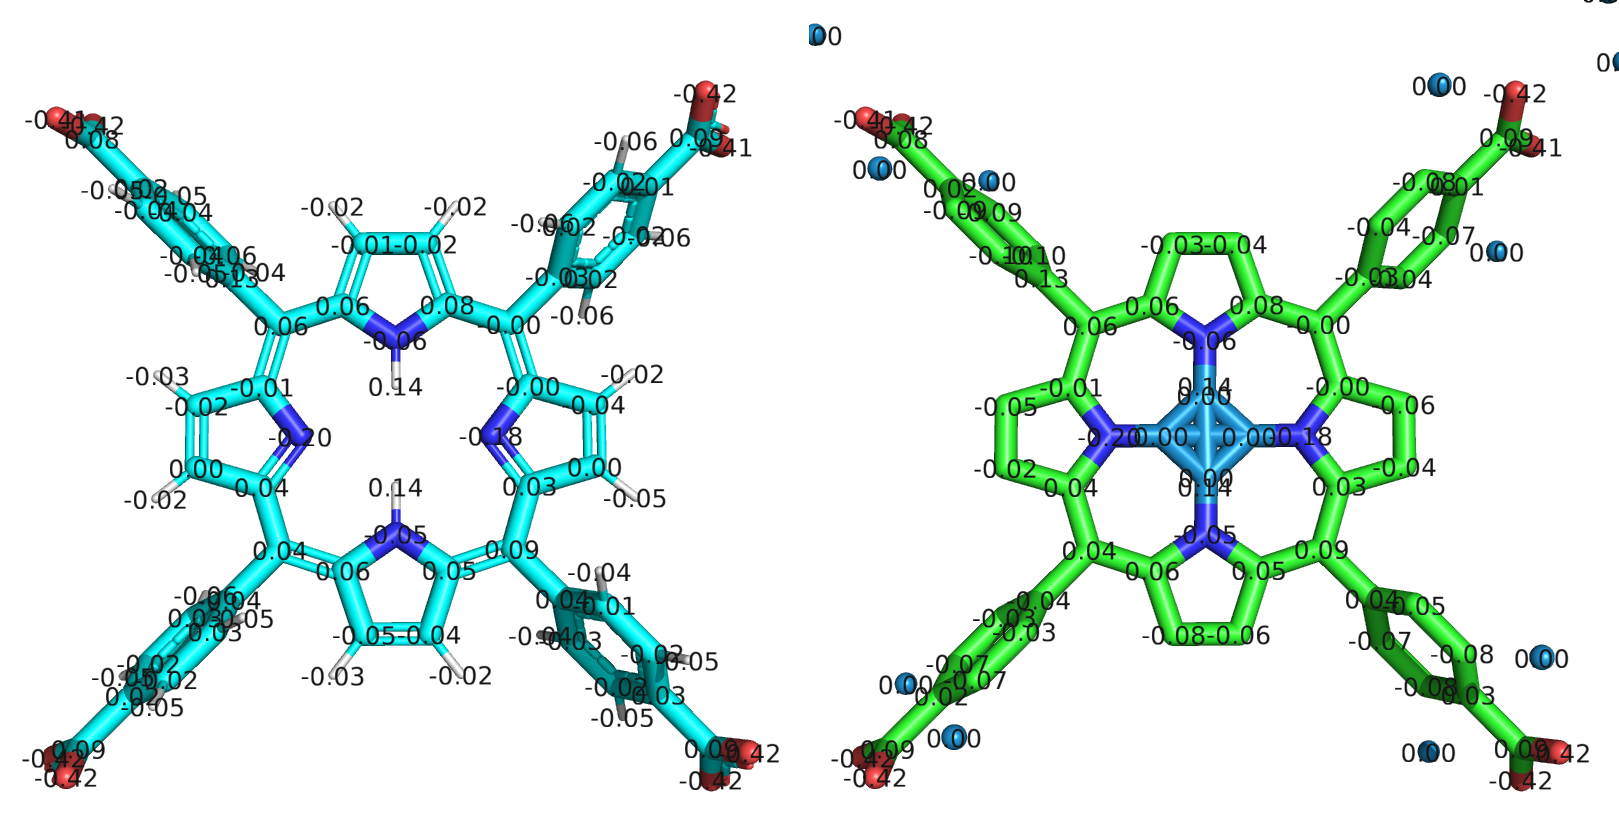

Then we parametrize the receptor using prepare_receptor in ADFR directory (or prepare_flexreceptor, which is provided for conveniency here)

In [6]:
! {PATH_ADFR}/prepare_receptor -r {receptor_file_pdb} -o {receptor_file} -v -A checkhydrogens
if (flex_residues != ""):
    ! {PYTHONSH} {REPOSITORY}/prepare_flexreceptor.py -r {receptor_file} -s {flex_residues} -v
    ! mv {receptor_name}_flex.pdbqt {site_name}.pdbqt
    rigid_receptor_name = f"{receptor_file.split('.pdbqt')[0]}_rigid.pdbqt"

set verbose to  True
set repairs to  checkhydrogens
read  receptor.pdb
setting up RPO with mode= automatic and outputfilename=  receptor.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


Prepare grid file

In [7]:
SIZE = 255 # Size of the docking box in Autodock units (default unit is 0.375 A). Maximum size is 255 units
os.chdir(PATH_TO_DOCKING)

# Optional: delete all files in the docking folder before running it again
clear_grid = False
if clear_grid:
    ! rm -rf {grid_name}*/*run*
    ! rm -rf {grid_name}*/*entity*
    ! rm -rf {grid_name}*/cluster*
    ! rm -rf {grid_name}*/*xml
    ! rm -rf {grid_name}*/*dlg

And run the Docking!

The script gen_grids generates grid files for all atom types of ligand and water and then accordingly modifies the map files. run_adgpu runs AutoDock-GPU and creates pose files with information on their energy and population. 

Simply copy printed commands and put them in the terminal in the main directory for docking of your ligand (running commands directly from Jupyter significantly worsens the perfomance).


For TCPP with 4000 LGA runs the total calculation takes ~10 minutes on RTX 4070.

In [301]:
NRUNS = 4000 # Number of docking runs: 1-8192
HEUR = 0 # Number of evaluations - optional. Set 0 for default.

if flex_residues != "":
    print(f"python3 {REPOSITORY}/gen_grids.py {PYTHONSH} {center_file} {rigid_receptor_name} {ligand_file} {SIZE} {REPOSITORY} {grid_name}")
    print(f"cp {site_name}.pdbqt {grid_name}1/")
    if(HEUR > 0):
        print(f"python3 {REPOSITORY}/run_adgpu_flex.py {rigid_receptor_name} {ligand_file} {NRUNS} 1 {site_name}.pdbqt {grid_name} {HEUR}")
    else:
        print(f"python3 {REPOSITORY}/run_adgpu_flex.py {rigid_receptor_name} {ligand_file} {NRUNS} 1 {site_name}.pdbqt {grid_name}")
else:
    print(f"python3 {REPOSITORY}/gen_grids.py {PYTHONSH} {center_file} {receptor_file} {ligand_file} {SIZE} {REPOSITORY} {grid_name}")
    if HEUR >0:
        print(f"python3 {REPOSITORY}/run_adgpu.py {receptor_file} {ligand_file} {NRUNS} 1  {grid_name} {HEUR}")
    else:
        print(f"python3 {REPOSITORY}/run_adgpu.py {receptor_file} {ligand_file} {NRUNS} 1  {grid_name}")

python3 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts//gen_grids.py /home/biomd/ADFRsuite-1.0/bin/pythonsh blind_center.xyz receptor.pdbqt tcpp_wat_charged.pdbqt 255 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts/ blind_site
python3 /home/biomd/Documents/GitHub/EPR-BindingSite/Scripts//run_adgpu.py receptor.pdbqt tcpp_wat_charged.pdbqt 5000 1  blind_site


And so we have obtained a large number of poses from blind docking. Now we have to clusterize them into several potential binding regions

# Analysis of results

## Parse results of docking 

['/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//Docking/tcpp/blind_site1']
['<cluster cluster_rank="1" lowest_binding_energy="-12.41" run="2140" mean_binding_energy="-10.50" num_in_clus="204"/>', '<cluster cluster_rank="2" lowest_binding_energy="-10.73" run="858" mean_binding_energy="-8.47" num_in_clus="157"/>', '<cluster cluster_rank="3" lowest_binding_energy="-10.59" run="975" mean_binding_energy="-9.20" num_in_clus="25"/>', '<cluster cluster_rank="4" lowest_binding_energy="-10.46" run="1799" mean_binding_energy="-8.82" num_in_clus="207"/>', '<cluster cluster_rank="5" lowest_binding_energy="-10.16" run="3686" mean_binding_energy="-8.44" num_in_clus="60"/>', '<cluster cluster_rank="6" lowest_binding_energy="-10.04" run="2009" mean_binding_energy="-7.97" num_in_clus="125"/>', '<cluster cluster_rank="7" lowest_binding_energy="-9.68" run="422" mean_binding_energy="-7.71" num_in_clus="109"/>', '<cluster cluster_rank="8" lowest_binding_energy="-9.42" run="1577" mean_binding_energy

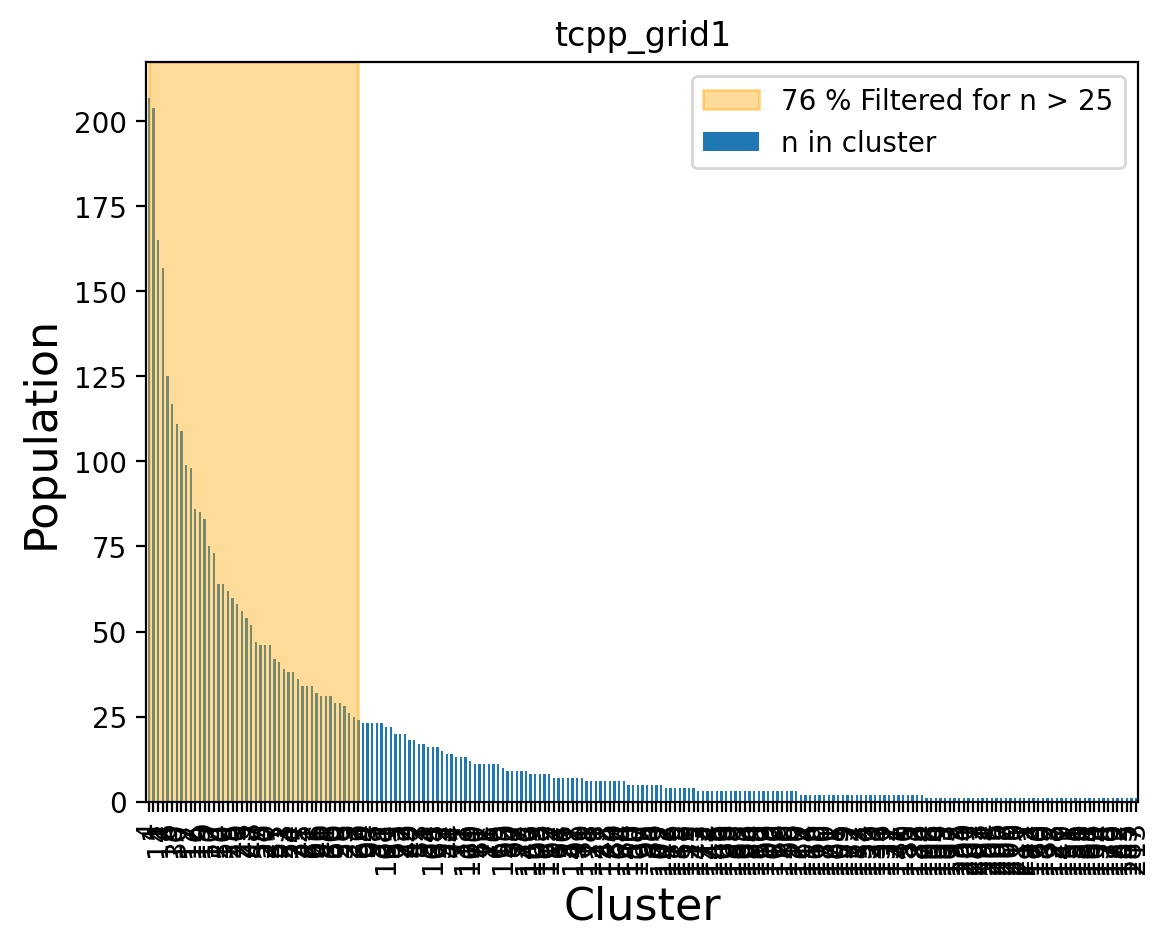

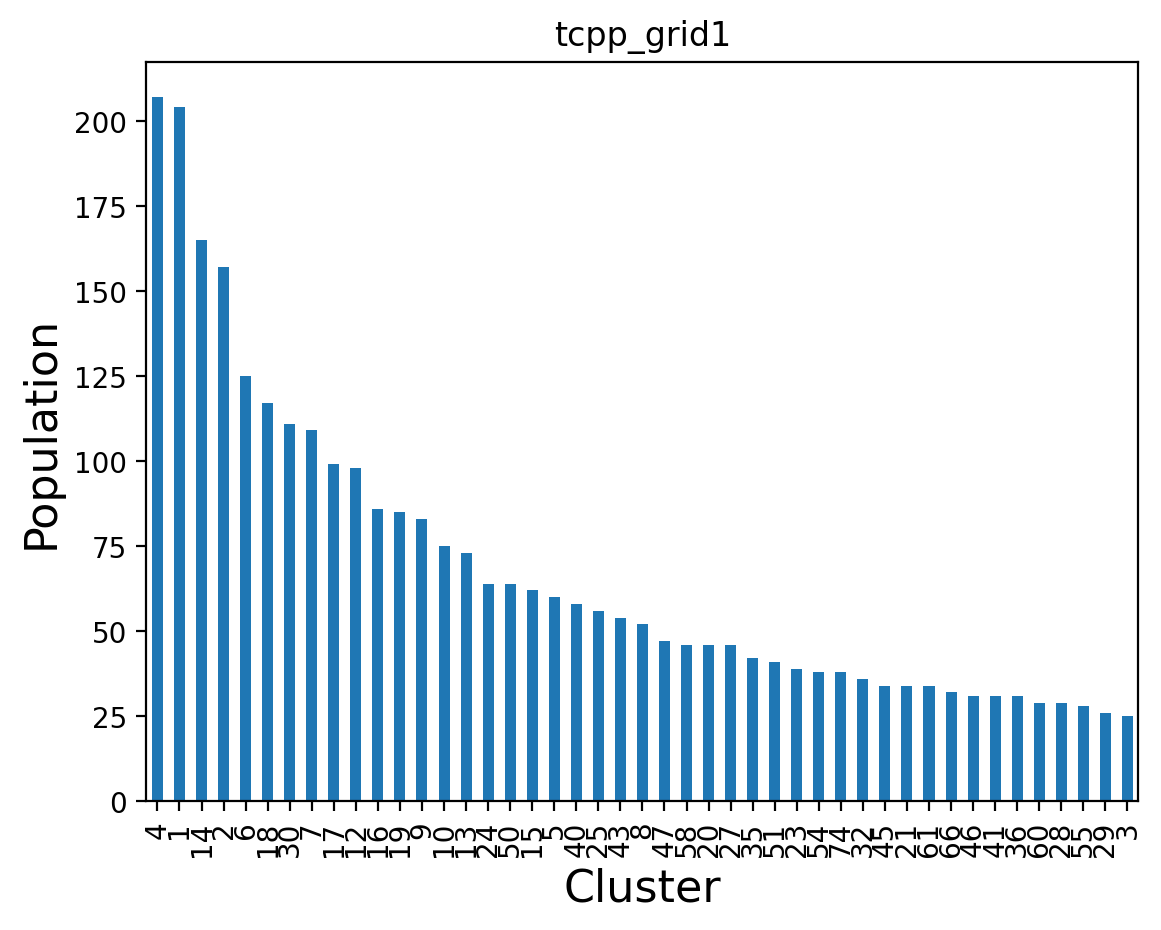

In [304]:
dataname=NAME # name of the ligand
FOLDNAME = NAME

iffilter = True
n_filter = 25 # Threshold of pose population to be filtered. Only poses with population more than n_filter will be considered
centers = glob.glob(f"{TARGET_PATH}/{grid_name}*")
i=0
print(centers)


k=0
fig_full = plt.figure(dpi=100) # Figure of all poses
fig = plt.figure(dpi=100) # Figure showing filtrated poses
pymol_load = [f'cd {grid_name}{i+1}; disable all; ' for i in range(1)]
for cent in centers:
	os.chdir(f"{TARGET_PATH}/{grid_name}{i+1}")
	# get parameters of poses
	energy = subprocess.getoutput("awk '/RANKING/ {if ($1==1 && $2==1) print $4;}' *.dlg")
	runs = glob.glob(f"{os.getcwd()}/*_run*")
	clusters = subprocess.getoutput("xmllint --xpath '//result/clustering_histogram/cluster' *.xml")
	# print(clusters)
	clusters = clusters.split("\n")
	print(clusters)
	cluster = np.empty(len(clusters),dtype = int)
	run_energy = np.empty(len(clusters),dtype = float)
	run = np.empty(len(clusters),dtype = int)
	nclust = np.empty(len(clusters),dtype = int)
	clustfile = np.empty(len(clusters),dtype = object)
	for idx, cl in enumerate(clusters):
		cl = cl.split()
		cluster[idx] = cl[1].split("=")[1].replace('"','')
		run_energy[idx] = cl[2].split("=")[1].replace('"','')
		run[idx] = cl[3].split("=")[1].replace('"','')
		nclust[idx] = cl[5].split("=")[1].replace("/>",'').replace('"','')
		clustfile[idx] = f"cluster{cluster[idx]}_{run_energy[idx]}_p{nclust[idx]}.pdbqt"
	# Get dataframe of docking results
	clust_data = pd.DataFrame(data={'cluster':cluster,'energy':run_energy, 'nrun':run, 'n in cluster':nclust, 'clusterfile':clustfile})
	clust_data = clust_data.sort_values(by=['n in cluster'], ascending=False)
	# Filter poses
	if iffilter:
		clust_data_filter=clust_data.query(f'`n in cluster` >={n_filter}')
	# Plot populations of each pose
	ax = fig_full.add_subplot(1,1,1)
	clust_data.plot.bar(x='cluster', y='n in cluster', ax=ax, legend=False)
	ax.axvspan(0, len(clust_data_filter), color='orange', alpha=0.4,
	 label = f"{round(clust_data_filter['n in cluster'].sum()/clust_data['n in cluster'].sum()*100)} % Filtered for n > {n_filter}")
	ax.legend()
	rects = ax.patches
	labels = clust_data['energy']
	for rect, label in zip(rects, labels):
		height = rect.get_height()
		# ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')
	ax.set_title(f"{dataname}_grid{i+1}")

	ax2 = fig.add_subplot(1,1,1)
	clust_data_filter.plot.bar(x='cluster', y='n in cluster', ax=ax2, legend=False)
	
	rects = ax2.patches
	labels = clust_data_filter['energy']
	for rect, label in zip(rects, labels):
		height = rect.get_height()
		# ax2.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, ha='center', va='bottom')
	
	ax2.set_title(f"{dataname}_grid{i+1}")
	for file in clust_data_filter['clusterfile']:
		pymol_load[i]+=f"load {file}; "
	i+=1
	print(f"Sum of population in obtained poses {clust_data_filter['n in cluster'].sum()}")
fs=16
ax.set_xlabel("Cluster", fontsize=fs)
ax.set_ylabel("Population", fontsize=fs)
ax2.set_ylabel("Population", fontsize=fs)
ax2.set_xlabel("Cluster", fontsize=fs)
fig.show()
fig_full.show()

name_pymol = f"{site_name}_{n_filter}_"
# Generate PyMol command to load all filtered results of docking in session
for idx,s in enumerate(pymol_load):
	pymol_load[idx]+=f" cd ..; group {name_pymol}{idx+1}, enabled"
print(f"Obtained {len(clust_data_filter)} poses")
# print("\n".join(pymol_load))
print("; ".join(pymol_load))

For TCPP you should get about 45 poses with the filter threshold of ~25
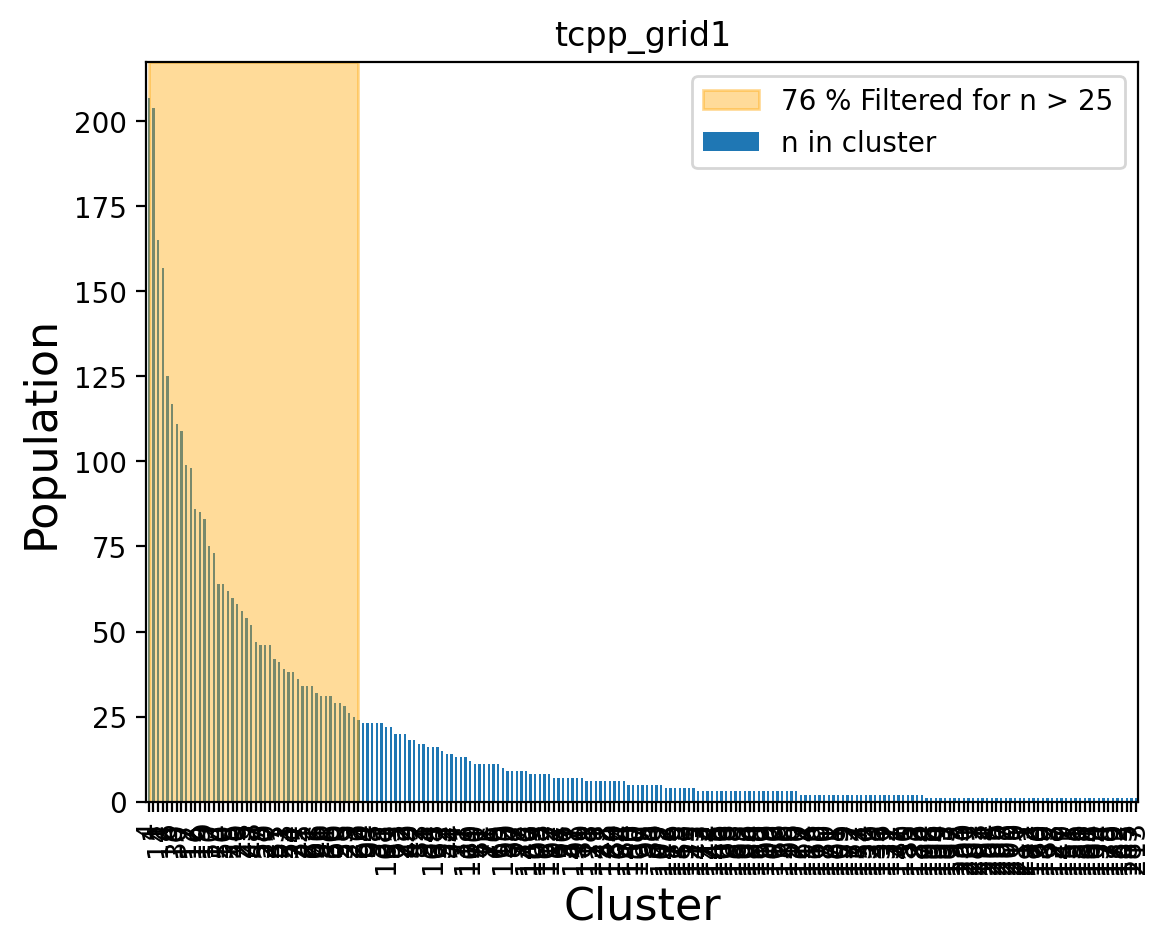

### Save chosen poses as pdb files

In [305]:
clusters_folder = f"clusters_{n_filter}"
os.chdir(f"{TARGET_PATH}/{grid_name}1")
if not(os.path.exists(clusters_folder) and os.path.isdir(clusters_folder)):
    os.makedirs(clusters_folder)
for file in clust_data_filter['clusterfile']:
    os.system(f"obabel -ipdbqt {file} -opdb > {clusters_folder}/{file.split('.pdbqt')[0]}.pdb")

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted


## Clusterize the results

Here we use the K-Means approach to clusterize poses obtained from blind docking

Get center and population of each pose left after filtering

In [306]:
CLUSTER_PATH = f"{TARGET_PATH}/{grid_name}1/{clusters_folder}/"
N_INIT = 150


num = len(glob.glob(CLUSTER_PATH + "*.pdb"))
centers = np.empty([num,3],dtype=float)
population = np.empty([num],dtype=float)
# out_centers = np.array(["0"]*(num), dtype = object)
# out_clust = np.array(["0"]*(CLUSTER_NUM), dtype = object)
i=0
for file in glob.glob(CLUSTER_PATH + "*.pdb"):
    dock = mda.Universe(file)
    lig = dock.select_atoms("all")
    licent = str(lig.center_of_geometry()).replace('[','').replace(']','')
    licent = licent.encode()
    licent = licent.decode()
    licent = licent.split()
    licent =np.array(licent,dtype='float')
    centers[i,:] = licent
    population[i] = int(file.split('.pdb')[0].split('_p')[1])
    i+=1
print(CLUSTER_PATH)

/home/biomd/Documents/GitHub/EPR-BindingSite/Examples//Docking/tcpp/blind_site1/clusters_25/


Calculate Silhoutte score and elbow graph metrics to determine the optimal number of clusters. 

In [307]:
import random
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

sil_score = []
distorsions = []
if len(centers) > 40:
    SK = range(2,40) # Clusterize for 2-40 clusters and calculate scoring metrics
else:
    SK = range(2,len(centers)-2)
rr = random.randrange(1,10000)
for i in SK:
    kmeans= KMeans(n_clusters=i,n_init=N_INIT, random_state=rr).fit(centers, sample_weight=population)
    labels= kmeans.labels_
    distorsions.append(kmeans.inertia_)
    sil = silhouette_score(centers,labels,metric="euclidean", random_state=rr)
    sil_score.append(sil)

In [308]:
import numpy.matlib
from kneed import KneeLocator

# Calculate Knee using kneed
def elb_kneed(wcss):
    K = range(2,len(wcss)+2)
    kneedle = KneeLocator(K, wcss, curve='convex', direction='decreasing', S=1)
    elbow_point = kneedle.elbow
    return elbow_point

### Plot clustering metrics and choose the optimal number of clusters

Optimal number of clusters: 11
0.45239590935089896


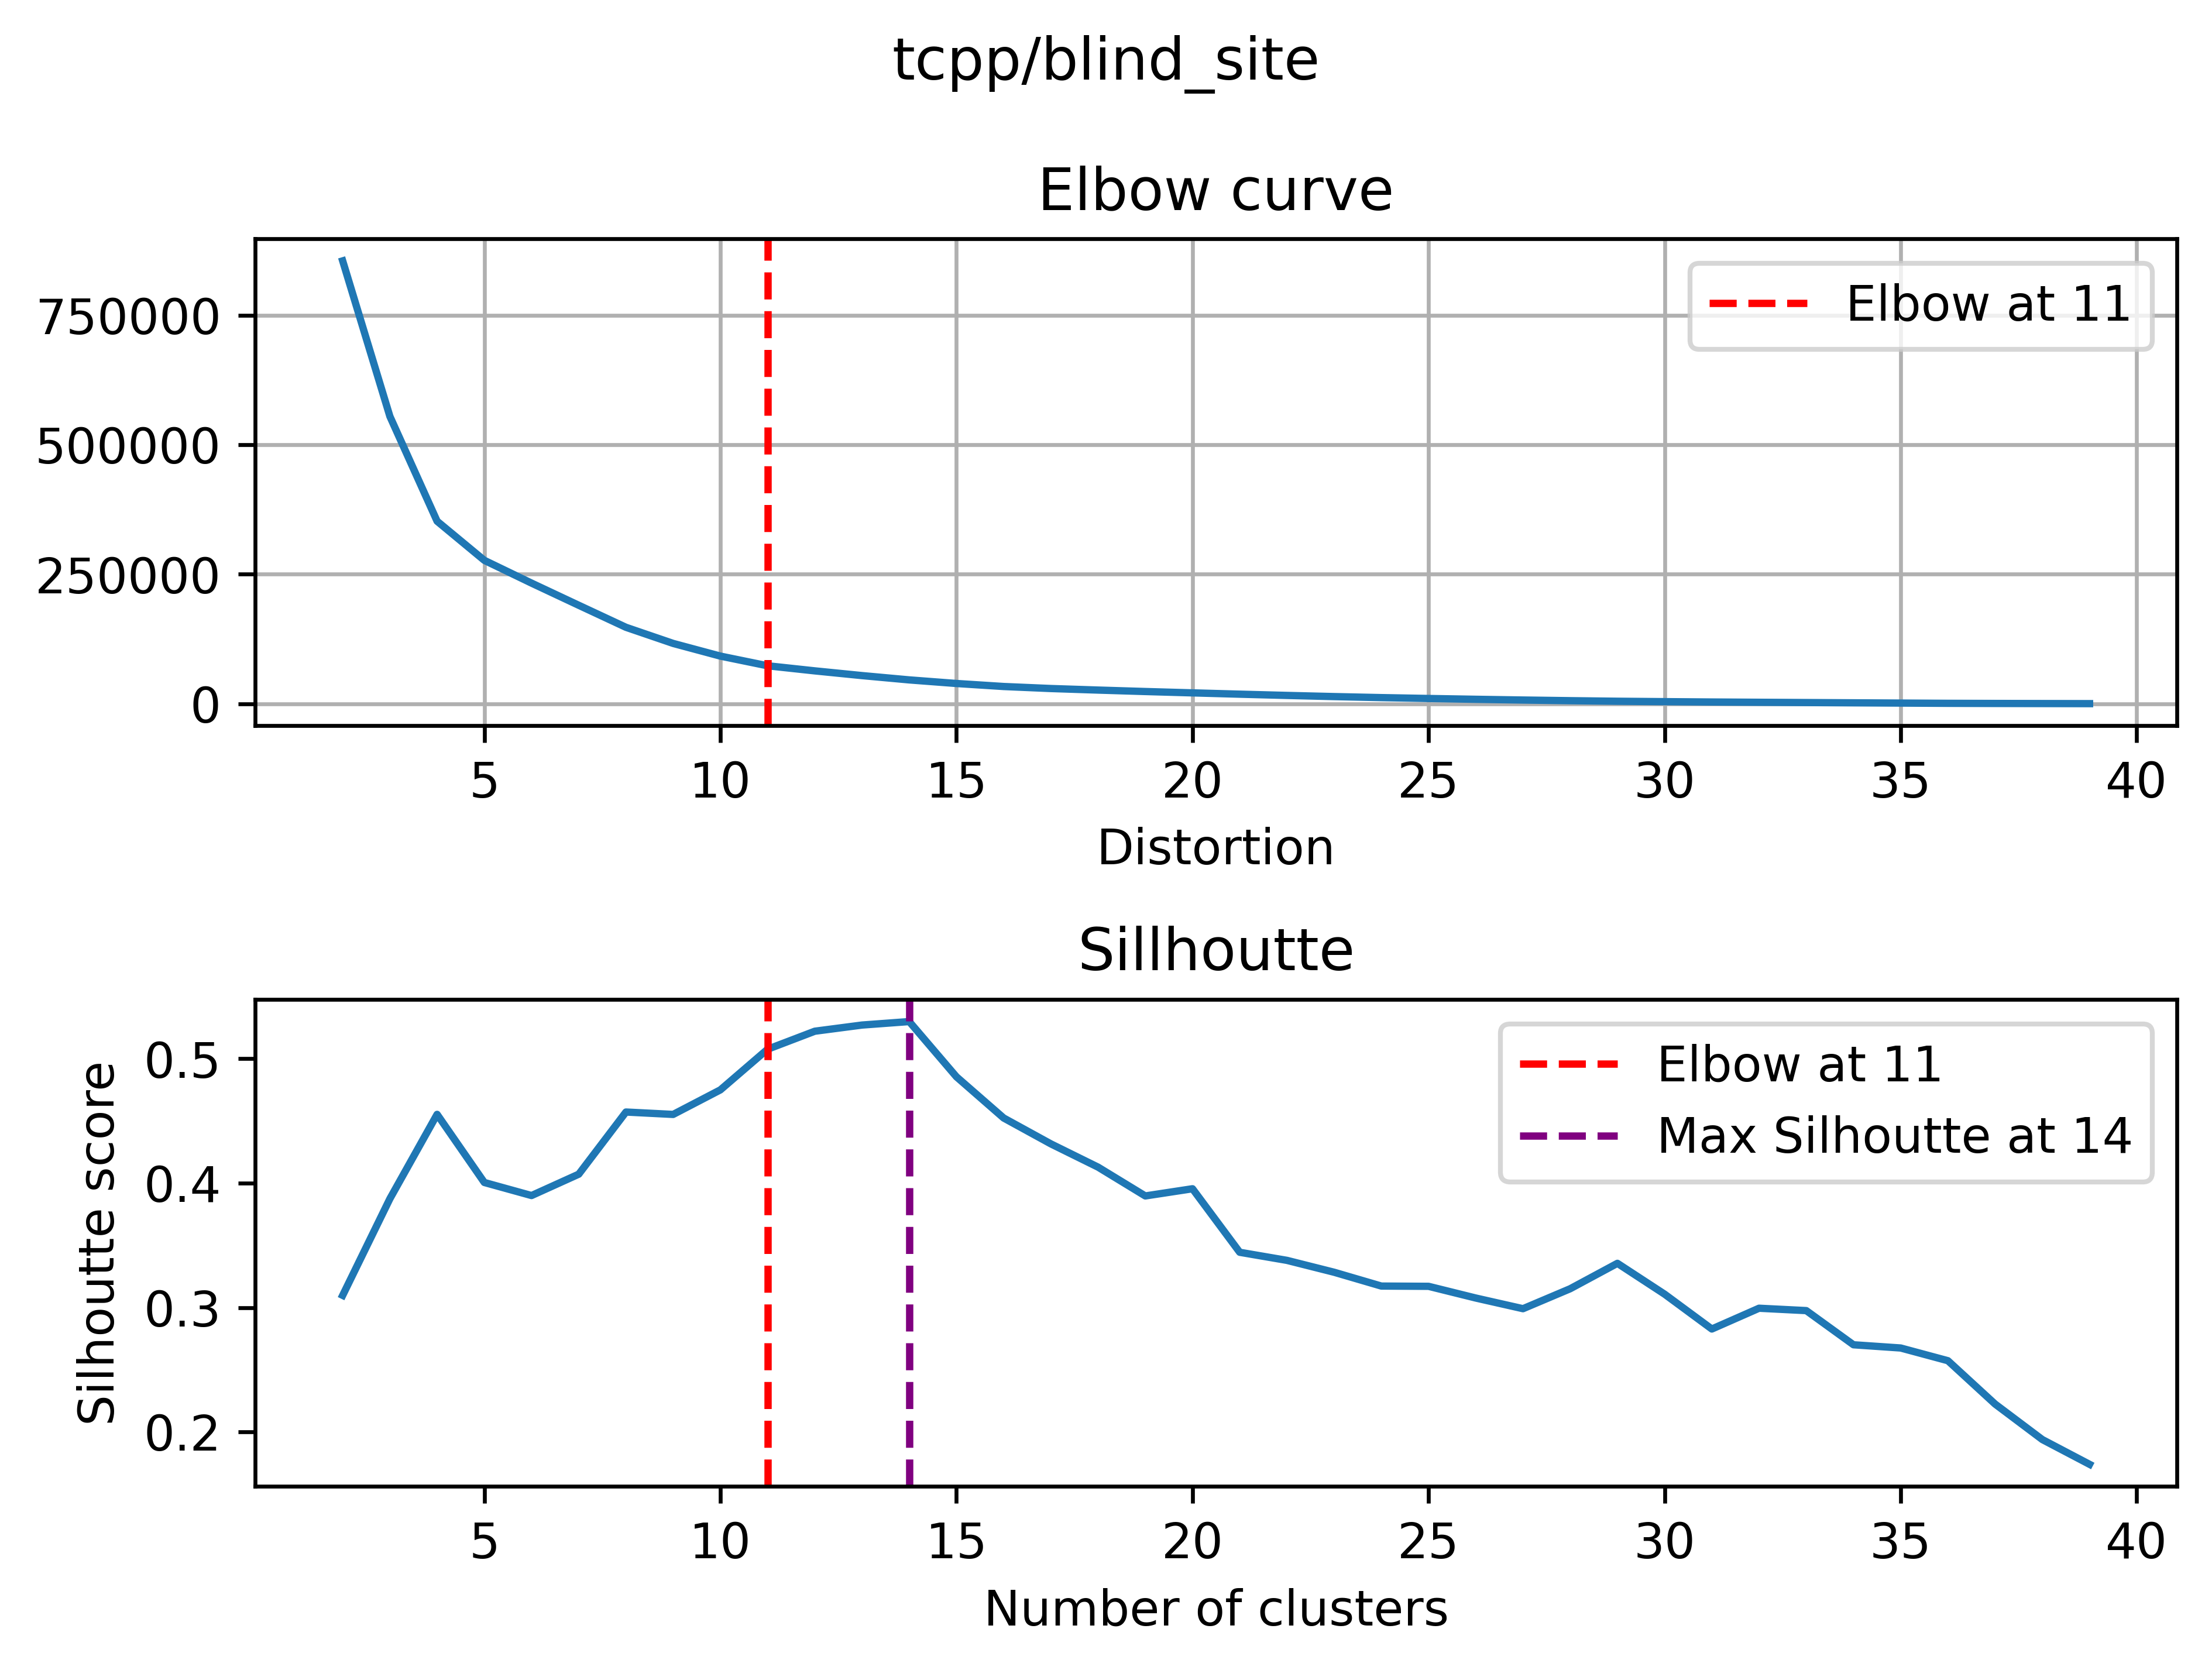

In [309]:
fig, (ax1, ax2) = plt.subplots(2,1,dpi=300)
ax1.plot(SK, distorsions)

elbow_point = elb_kneed(distorsions) + 1  # +1 because index starts from 0

print(f'Optimal number of clusters: {elbow_point}')
ax1.axvline(x=elbow_point, linestyle='--', color='red', label = f"Elbow at {elbow_point}")
ax1.legend()
ax1.grid(True)
ax1.set_title('Elbow curve')
ax1.set_xlabel("Number of clusters")
ax1.set_xlabel("Distortion")

# sil_centers = pd.DataFrame({'Clusters' : SK, 'Sil Score' : sil_score})
ax2.plot(SK, sil_score)
ax2.set_title('Sillhoutte')
sil_max = np.argmax(np.abs(sil_score)) + 2
print(sil_score[sil_max])
ax2.axvline(x=elbow_point, linestyle='--', color='red', label = f"Elbow at {elbow_point}")
ax2.axvline(x=sil_max, linestyle='--', color='purple', label = f"Max Silhoutte at {sil_max}")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhoutte score")
ax2.legend()


fig.suptitle(f"{FOLDNAME}/{grid_name}")
fig.tight_layout()
fig.show()

Generally when choosing the optimal number of K-Means we are interested in two metrics:

 1) The location of the "knee" in the Elbow curve 
 2) The maximum of the Silhoutte score.

However, different metrics may provide different optimal numbers. In this case it is advised to choose the larger number (if it is not too large). In our practice the number of clusters is generally 9-13. This can be later verified by visual analysis.


For TCPP you should get something like this:
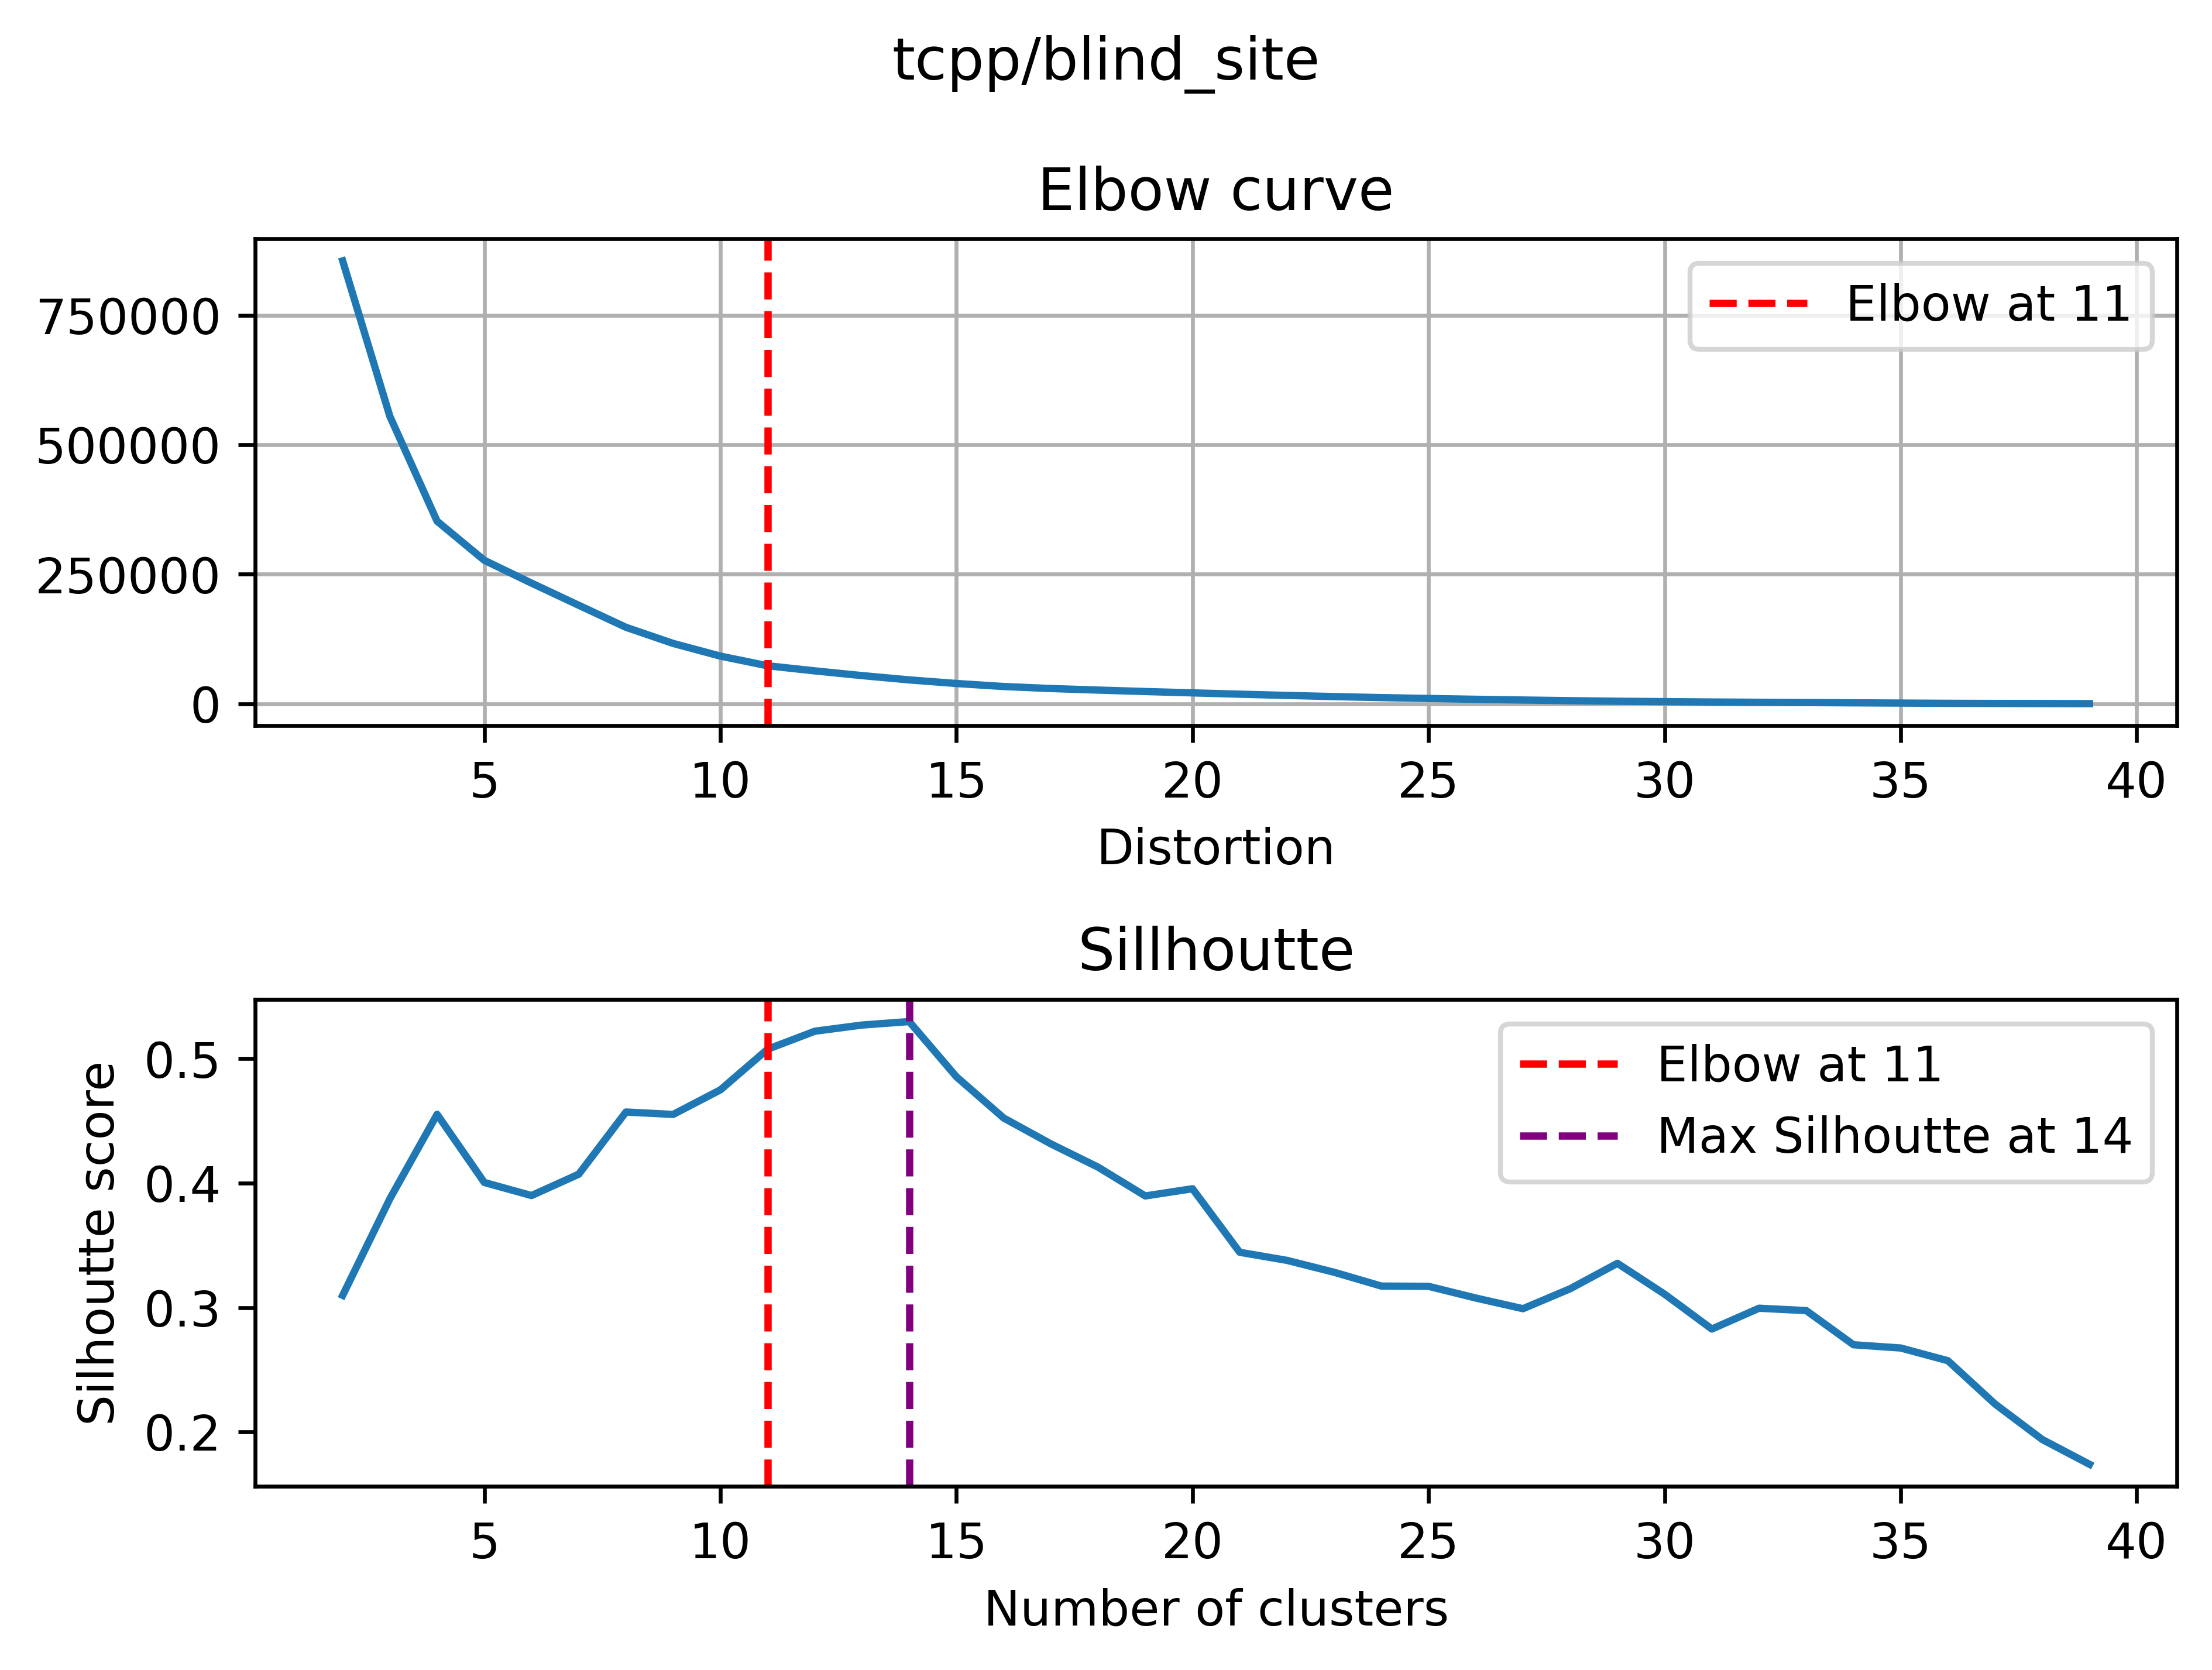

We can also plot dendrogram for additional visualizatoin of clustering

4


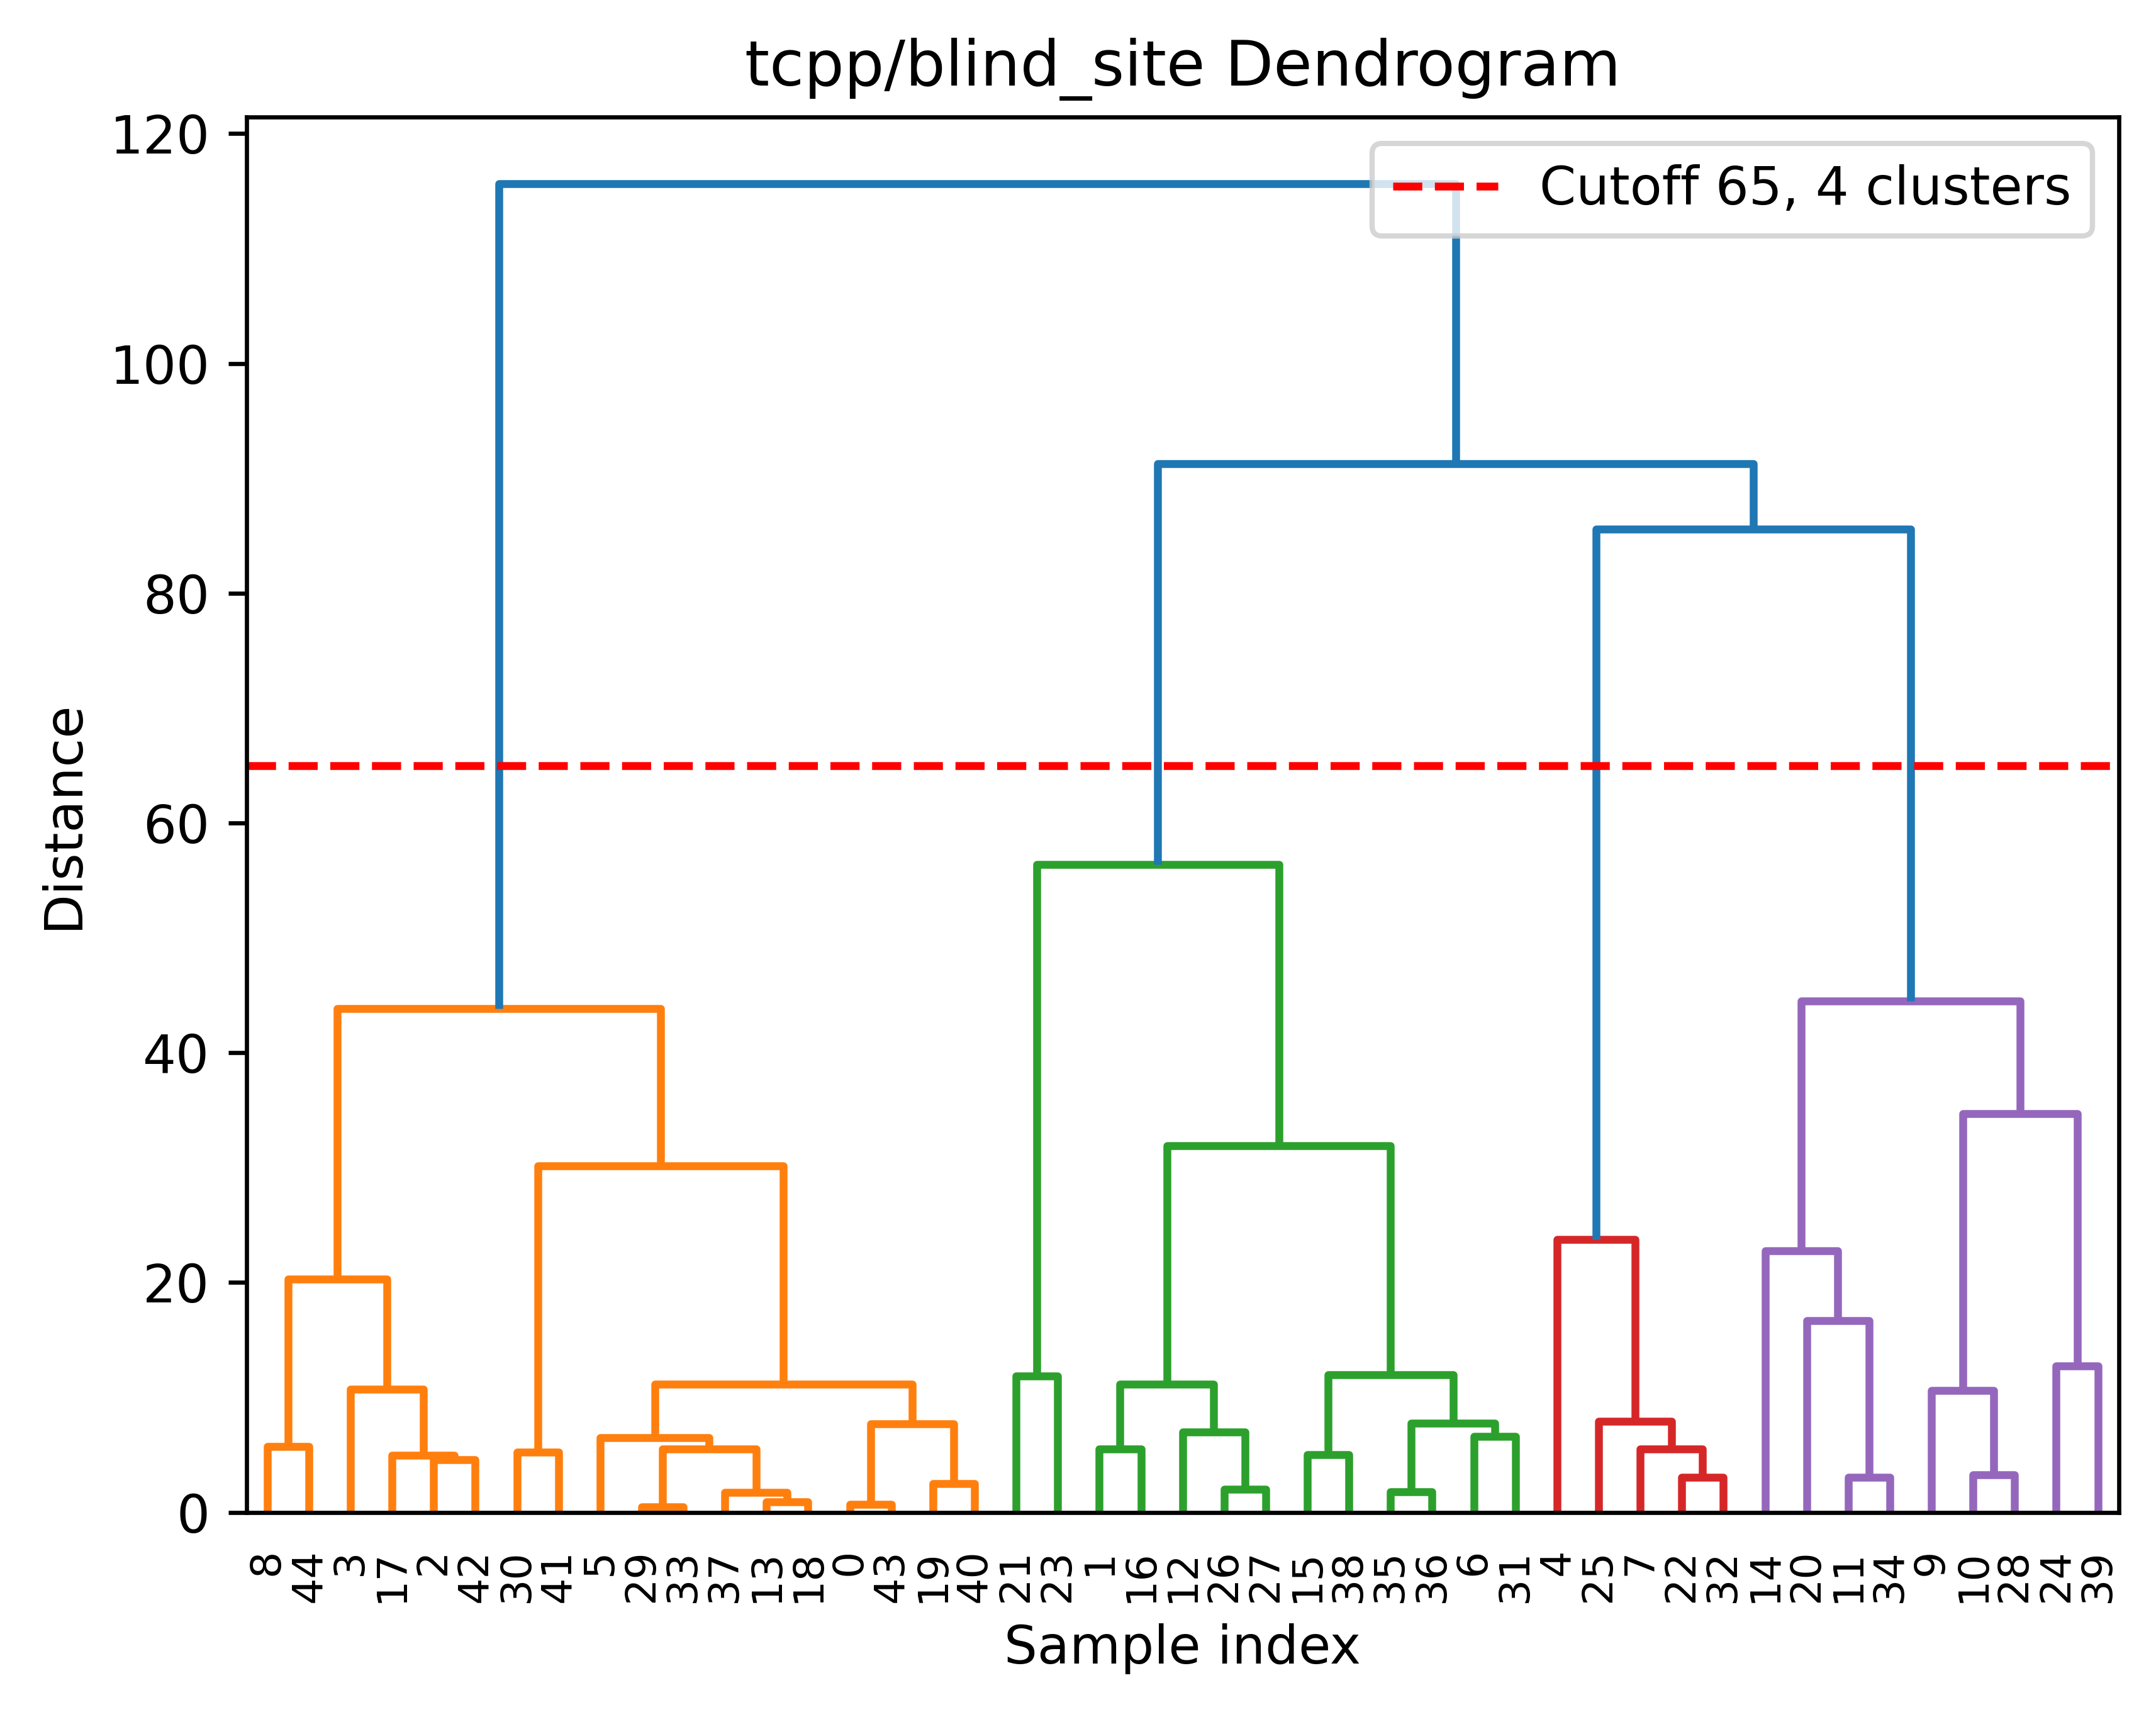

In [310]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
max_d = 65  # This is the distance threshold
Z = linkage(centers, method='ward', metric='euclidean')
clusters_cut = fcluster(Z, max_d, criterion='distance')
plt.figure(dpi=300)
dendrogram(Z)
plt.axhline(y=max_d,linestyle='--', color='red', label = f"Cutoff {max_d}, {max(clusters_cut)} clusters")
plt.title(f"{FOLDNAME}/{grid_name} Dendrogram")
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.legend()
print(max(clusters_cut))
# Z_cut = linkage(clusters_cut, method='ward')
# dendrogram(Z_cut)
plt.show()

## Generate clusters

For TCPP we are going to choose 11 clusters according to elbow curve, as this number is close to the number provided by Silhoutte score.  

In [311]:
NUM_CLUSTERS = 11 # Final number of clusters

kmeans = KMeans(n_clusters=NUM_CLUSTERS, n_init=N_INIT).fit(centers, sample_weight = population)
labels = kmeans.predict(centers)
centroids = kmeans.cluster_centers_
out_centers = np.array(["0"]*(num), dtype = object)
out_clust = np.array(["0"]*(NUM_CLUSTERS*3), dtype = object)
weights = np.zeros([num],dtype=float)

for j,l in enumerate(labels):
    weights[l] += population[j]
i=0

combined = list(zip(centroids, weights))
# Sort based on the weights
sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
# Unzip the sorted arrays
sorted_centroids, sorted_weights = zip(*sorted_combined)

for clust in sorted_centroids:
    cen = str(clust).replace('[','').replace(']','')
    cen = "F    "+ cen
    out_clust[i] = f"1"
    out_clust[i+1] = f"KM{i//3}_{NAME}_p{round(sorted_weights[i//3])}"
    out_clust[i+2] = cen
    i+=3


out_centers = np.insert(out_centers, 0,f"Coordinates of clusters for {NAME}")
# out_clust = np.insert(out_clust, 0,f"Clusterized {CLUSTER_NUM} pockets for {NAME}")
np.savetxt(CLUSTER_PATH + f'{NAME}_centers.xyz',out_centers,fmt="%s", encoding = 'latin1')
np.savetxt(CLUSTER_PATH + f'{NAME}_clusters_{NUM_CLUSTERS}.xyz',out_clust,fmt="%s", encoding = 'latin1')

# Visualize results

Here we use the ChiLife library to calculate average distances from clusters to the spin label

In [312]:
import chilife as xl
forgive = 1 # Set forgiveness factor for the spin label (how strict are the clashes treated)

os.chdir(f"{PATH_TO_DOCKING}")
rec = mda.Universe(f"{PATH_TO_DOCKING}/{receptor_name}.pdb") # Load receptor
# Generate Spin Label conformations
class CustomEnergyFunc(xl.ljEnergyFunc):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ljFunc = super().__call__
        self.func_forgive = forgive

    def __call__(self, rotens):
        ljE = self.ljFunc(rotens, forgive=self.func_forgive)
        return ljE 


my_energy_func = CustomEnergyFunc(functional=xl.get_lj_energy)

SL_label = xl.SpinLabel('R1M', site=34, protein=rec, dihedral_sigmas=np.inf,
                         sample=40000, energy_func = my_energy_func, use_H = False)
print(f"{len(SL_label)} Spin Conformations")
# Save protein with modeled spin labels
xl.save(f"{receptor_name}_withSL.pdb", SL_label, rec, write_spin_centers=False)
xl.save(f"{receptor_name}_onlySL.pdb", SL_label, write_spin_centers=False)

10 Spin Conformations


In [313]:
obt_clusters = mda.Universe(f"{CLUSTER_PATH}/{NAME}_clusters_{NUM_CLUSTERS}.xyz")
obt_clusters.add_TopologyAttr('resname')
print(len(obt_clusters.trajectory))
distances = np.zeros(len(obt_clusters.trajectory))
for idx in range(len(obt_clusters.trajectory)):
    obt_clusters.trajectory[idx]
    sel = obt_clusters.select_atoms(f"name F")
    for res in sel.residues:
            res.resname = "TMP"
    SL_cl = xl.IntrinsicLabel("TMP", sel, spin_atoms="F")
    r = np.linspace(0, 100, 1000)
    P = xl.distance_distribution(SL_label, SL_cl, r=r, use_spin_centers=False,
        sigma=0.5)
    mean=np.mean(np.dot(r,P))/sum(P)
    distances[idx] = int(mean)
print(distances)

11
[25. 52. 42. 39. 24. 54. 50. 39. 31. 20. 50.]


Create .pse PyMol session with receptor, spin labels and obtained clusters, or append the results into existing one.

In [326]:
import pymol
from pymol import cmd,stored

def labelClust(selname, divider):
    divider = str(divider)
    seleobj = cmd.get_object_list(selname)
    for obj in seleobj:
        # print(obj, divider)
        name = f"{obj.split(divider)[-1]} "
        if divider[-1] == 'p': # for population to easy
            cmd.label(obj,f'"p{name}"')
        else:
            cmd.label(obj,f'"{name}"')

# Calculate average distance from the cluster center to the spin label
# Not used in this script but can be imported in PyMol. Just select an atom in edit mode and run the script
def avdist_Spin_Cluster(nameSelection = "pk1", spinlabel="C34R1"):
    seleobjs = cmd.get_object_list(nameSelection)
    for obj in seleobjs:
        labelobj = cmd.get_object_list(spinlabel)
        labelname = ""
        statenum = cmd.count_states(spinlabel)
        dist=np.zeros(statenum)
        for i in range(statenum):
                dist[i]+=(cmd.get_distance(atom1=f"{obj}", atom2=f"{spinlabel} and name O1", state = i))
        avdist = np.mean(dist)
        disp = np.std(dist)
        # print("Average distance is ", avdist)
        # print("Dispersion is ", disp)
        if(obj[-1] !='A'):
            cmd.set_name(obj, f"{obj}_{round(avdist)}A")
cmd.extend("avdist_Spin_Cluster", avdist_Spin_Cluster)

def appendSpinDist(nameSelection, distances):
    seleobjs = cmd.get_object_list(nameSelection)
    for idx, obj in enumerate(seleobjs):
        print(obj)
        if(obj[-1] !='A'):
            cmd.set_name(obj, f"{obj}_{int(distances[idx])}A")
cmd.extend("appendSpinDist", appendSpinDist)

def getCluster_params(selname, divider):
    data = []
    divider = str(divider)
    seleobj = cmd.get_object_list(selname)
    pops = np.zeros(len(seleobj))
    dists = np.zeros(len(seleobj))
    for idx,obj in enumerate(seleobj):
        print(obj, divider)
        name = f"{obj.split(divider)[-1]} "
        if divider[-1] == 'p': # for population for convenience
            name = f"p{name}"
        pop = int(name.split('_')[0][1:])
        dist = int(name.split('_')[1][:-2])
        pops[idx] = pop
        dists[idx] = dist
        data.append({'Cluster Population': pop, 'Average Distance (A)': dist})
    df = pd.DataFrame(data)
    # Rename the index
    df.index.name = "Cluster Number"
    df.index +=1
    df = df.T
    return pops, dists, df

In [327]:
pymol_name = f"{NAME}_docking.pse"
os.chdir(PATH_TO_DOCKING)
if not os.path.isfile(pymol_name):
    cmd.delete("all")
    cmd.load(f"{receptor_name}_SL.pdb")
    cmd.load(CLUSTER_PATH + f'{NAME}_clusters_{NUM_CLUSTERS}.xyz')
    cmd.split_states(f"{NAME}_clusters")
    cmd.delete(f"{NAME}_clusters")
    cmd.group(f"{NAME}_{site_name}_clusters", "KM*")
    for file in clust_data_filter['clusterfile']:
        cmd.load(f"{TARGET_PATH}/{grid_name}1/" + file)
    cmd.remove("name WAT")
    cmd.group("poses", f"cluster*_*")
    appendSpinDist("KM*", distances)
    labelClust("KM*", "_p")
    clust_pop, clust_dist, table = getCluster_params("KM*", "_p")

    cmd.zoom(f"receptor")

    cmd.save(pymol_name)
else:
    cmd.load(pymol_name)
    clust_pop, clust_dist, table = getCluster_params("KM*", "_p")


KM0_tcpp_p680_25A _p
KM1_tcpp_p515_52A _p
KM2_tcpp_p465_42A _p
KM3_tcpp_p413_39A _p
KM4_tcpp_p315_24A _p
KM5_tcpp_p203_54A _p
KM6_tcpp_p111_50A _p
KM7_tcpp_p109_39A _p
KM8_tcpp_p81_31A _p
KM9_tcpp_p78_20A _p
KM10_tcpp_p77_50A _p


Show Dataframe with information about clusters

In [316]:
table

Cluster Number,1,2,3,4,5,6,7,8,9,10,11
Cluster Population,680,515,465,413,315,203,111,109,81,78,77
Average Distance (A),25,52,42,39,24,54,50,39,31,20,50


In the end you should get something like this:


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Cluster Number</th>
      <th>1</th>
      <th>2</th>
      <th>3</th>
      <th>4</th>
      <th>5</th>
      <th>6</th>
      <th>7</th>
      <th>8</th>
      <th>9</th>
      <th>10</th>
      <th>11</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Cluster Population</th>
      <td>680</td>
      <td>515</td>
      <td>465</td>
      <td>413</td>
      <td>315</td>
      <td>203</td>
      <td>111</td>
      <td>109</td>
      <td>81</td>
      <td>78</td>
      <td>77</td>
    </tr>
    <tr>
      <th>Average Distance (A)</th>
      <td>25</td>
      <td>52</td>
      <td>42</td>
      <td>39</td>
      <td>24</td>
      <td>54</td>
      <td>50</td>
      <td>39</td>
      <td>31</td>
      <td>20</td>
      <td>50</td>
    </tr>
  </tbody>
</table>
</div>

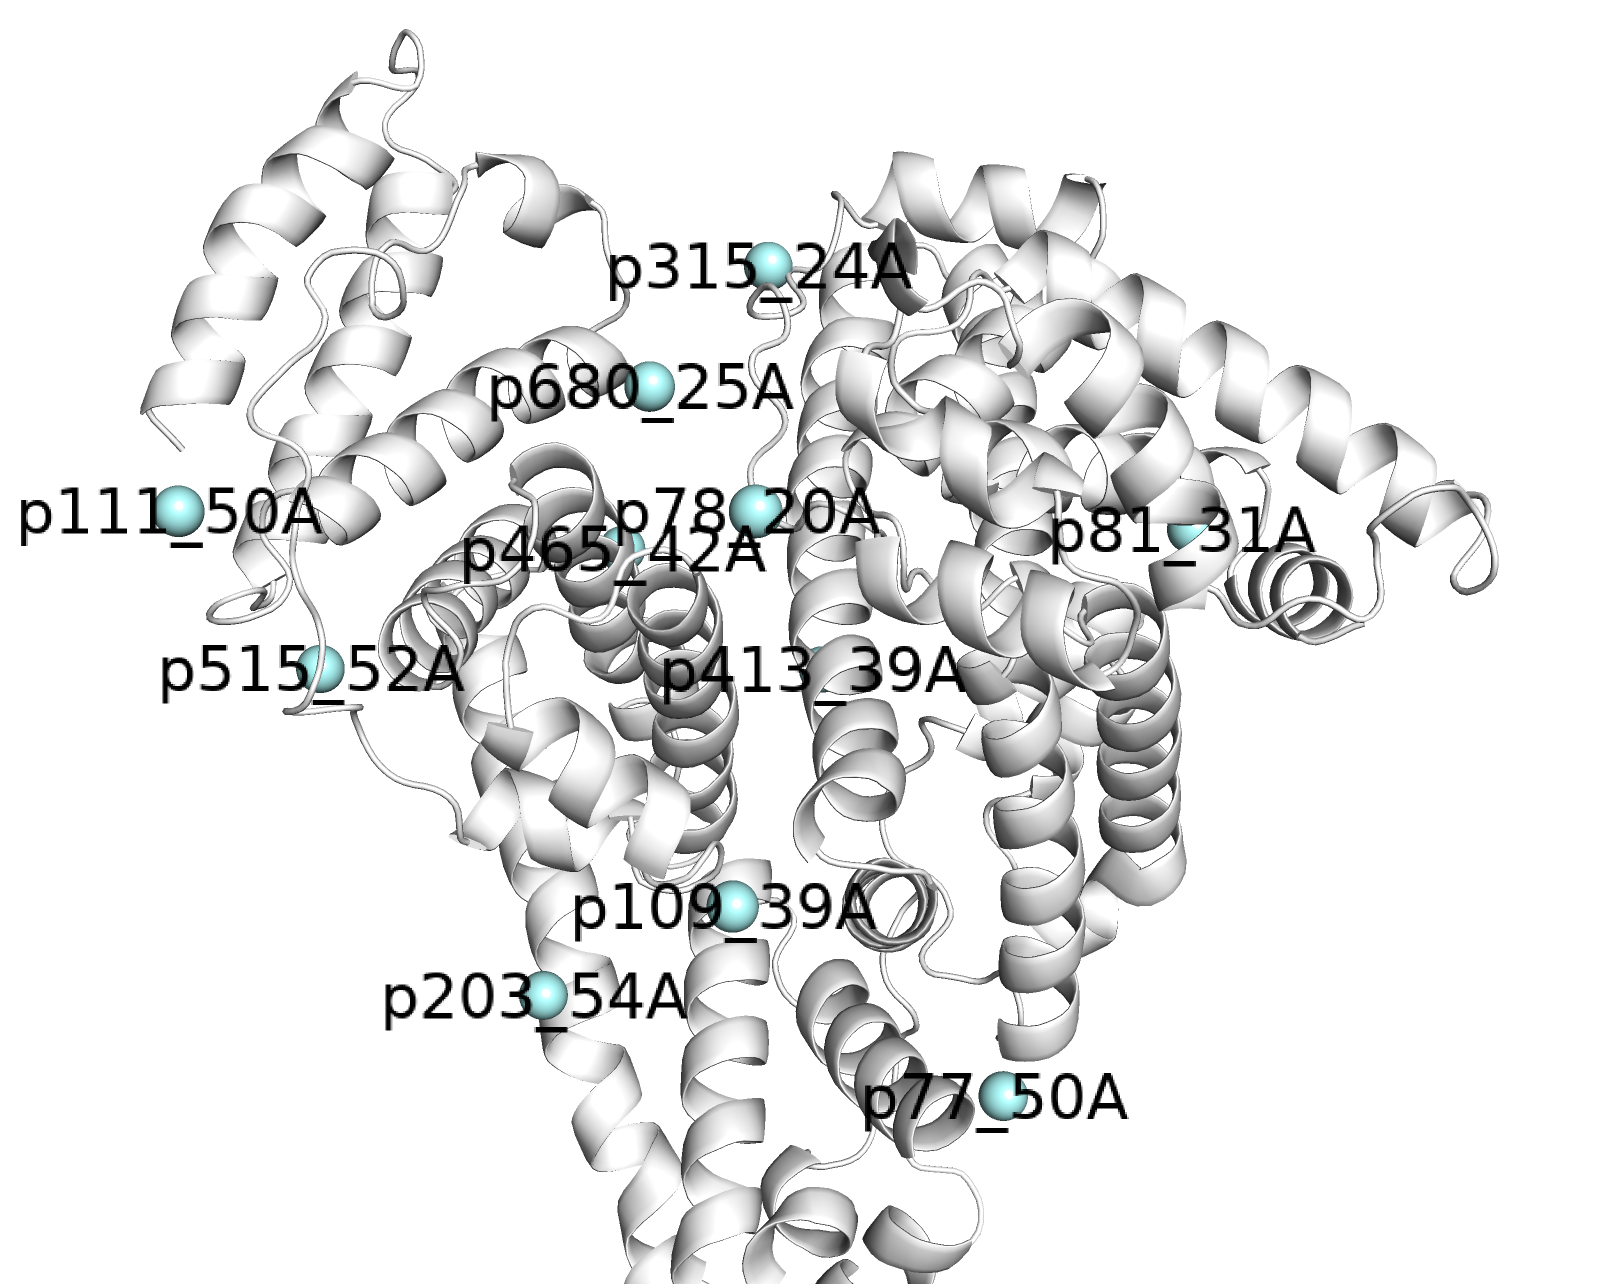

# Compare results with EPR distance distributions (to be continued)

In the TCPP folder we have TCPP_Distribution.dat file with MTSL-TCPP distance distributions obtained from DeerAnalysis. Let's compare computed distances from clusters with the experiment!

In [317]:
# Path to the *distr.dat file from DeerAnalysis
distr_file = f"{HOME}/TCPP/TCPP_Distribution.dat"
distr = np.loadtxt(glob.glob(distr_file)[0])
distr[:,1], distr[:,2], distr[:,3] = distr[:,1]/max(distr[:,1]), distr[:,2]/max(distr[:,1]), distr[:,3]/max(distr[:,1])
distr[:,0] = distr[:,0]*10

In [334]:
# Dictionary of cluster populations
avdist_dict = {
    f"{NAME}": clust_dist
    }
# Dictionary of MTSL-cluster distances
population_dict = {
    f"{NAME}": clust_pop
    }
# Dictionary of clusters that will be labeled red
selectedclust_dict = {
    f"{NAME}": [0,1,2,3]}

In [335]:
def clust_plot_distr(ax, chosen, distr,avpop,avdist, plot_lines=True, hide_axis=True):
    csfont = {'family':'Arial'}
    color_main = 'black'
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax1.get_yaxis().set_visible(False)
    
    ax.plot(distr[:,0],distr[:,1], label = 'Experimental', color=color_main, linewidth=3)
    # ax1.fill_between(distr[:,0],distr[:,2],distr[:,3], alpha=0.3, color=color_main)

    chosen = selectedclust_dict[NAME]
    if plot_lines:
        for idx,d in enumerate(avdist):
            c = 'red' if idx in chosen else 'black'
            ax.axvline(x=int(d), ymin=0, ymax=1, color=c, linestyle='--', linewidth=1.5)
    csfont = {'family':'Arial'}
    fs = 18
    ax.set_xlim(10,70)
    ax.set_ylim(bottom=0)
    if hide_axis:
        ax.get_xaxis().set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    else:    
        ax.set_xlabel("Distance, Å", fontsize=fs, **csfont)
        ax.set_ylabel('Distance\nDistribution', fontsize=fs, **csfont)
        ax.tick_params(axis='both',labelsize=fs-4)

def clust_plot_pops(ax,chosen, distr, avpop, avdist):
    fs = 27
    csfont = {'family':'Arial'}
    maxy= max(avpop)+100
    ax.set_ylim(0,maxy)
    ax.set_xlim(10,70)
    ax.tick_params(axis='both',labelsize=14)
    for idx, d in enumerate(avdist):
        c = 'red' if idx in chosen else 'black'
        ax.scatter(avdist[idx],avpop[idx], facecolors='none', edgecolors=c, s = 700*avpop[idx]/5000)
        ax.axvline(x=int(d), ymin=avpop[idx]/maxy, ymax=1, color=c, linestyle='--', linewidth=0.8)
    ax.set_xlabel("Average distance to spin label, Å", fontsize=fs, **csfont)
    ax.set_ylabel(r"Cluster population", fontsize=fs, **csfont)

[25. 52. 42. 39. 24. 54. 50. 39. 31. 20. 50.]
2 465 515
3 413 465


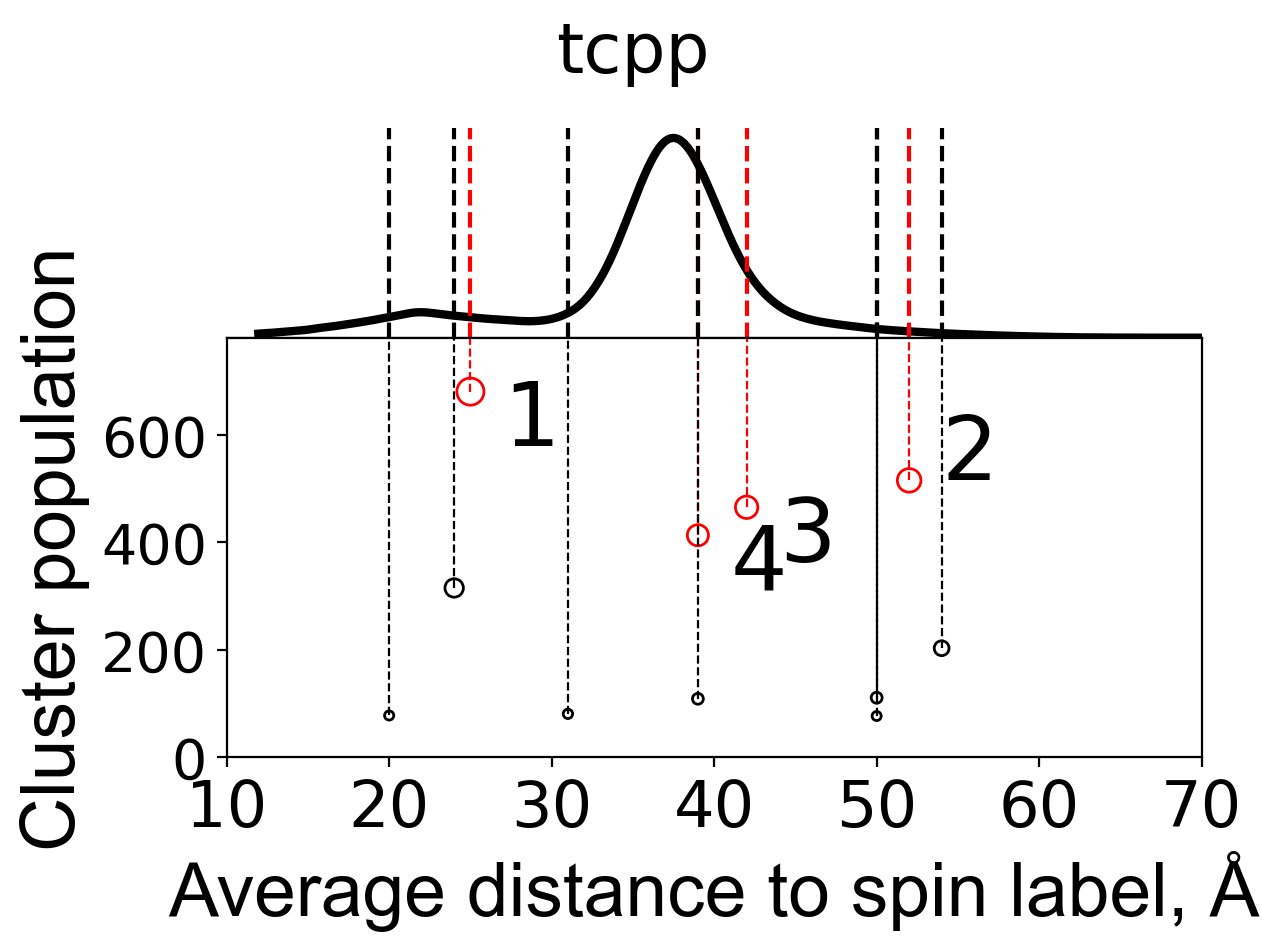

In [336]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[1,2])

avdist = avdist_dict[NAME]
print(clust_dist)
avdist = [int(item) for item in avdist]
avpop = population_dict[NAME]
avpop = [int(item) for item in avpop]
chosen = selectedclust_dict[NAME]

clust_plot_distr(ax1,chosen, distr, avpop, avdist)
clust_plot_pops(ax2,chosen, distr, avpop, avdist)
l=0
dm1, pm1 = 0, 0
for idx in chosen:
    d,p = avdist[idx],avpop[idx]
    if idx>0 :
        if (p-pm1<10 and d-dm1<4):
            ax2.text(d+2, p-100, l+1, fontsize=fs+7)
            print(idx, p, avpop[idx-1])
        else:
            ax2.text(d+2, p+2, l+1, fontsize=fs+7)
    else:
        ax2.text(d+2, p-100, l+1, fontsize=fs+7)
    l+=1
    dm1, pm1 = d, p
fs=25
fig.suptitle(NAME, fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-5)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

We can see that the most populated cluster corresponds to the very weak peak, while the second cluster corresponds to nothing. Only third and fourth clusters correspond to the main peak in the distribution.
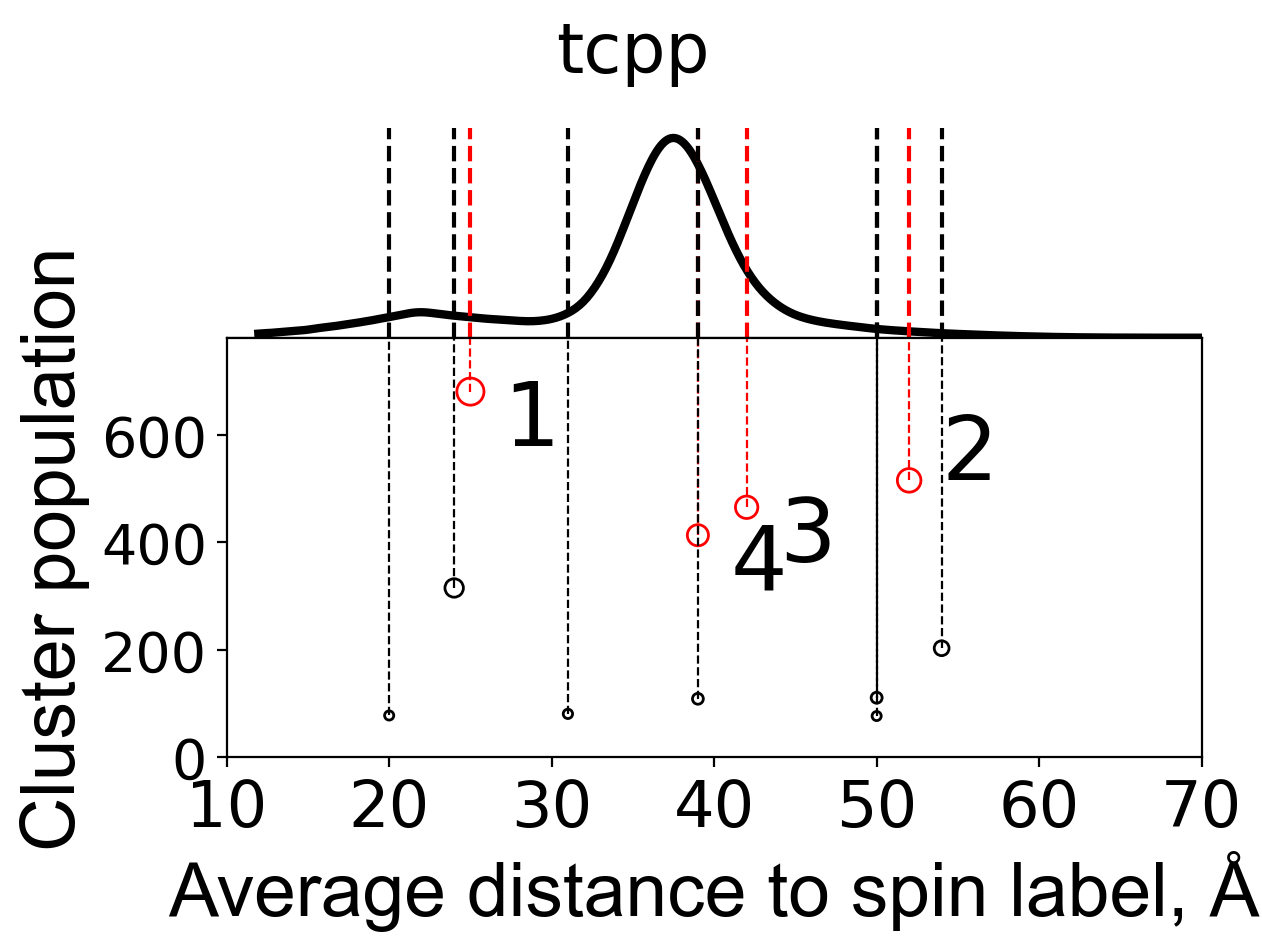